In [2]:
import os
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set working directory here
WD = '/Users/johnmichael/Documents/vm-spinal-risk/vm-spinal-risk'

In [4]:
risk_survey = pd.read_csv(os.path.join(WD, 'data/RiskTrial2_DATA_2024-01-18_2039.csv'))

In [5]:
# Check how many incomplete survey submissions
risk_survey[risk_survey.risk_trial_complete == 0]

record_id  redcap_survey_identifier risk_trial_timestamp  \
15         16                       NaN      [not completed]   
36         37                       NaN      [not completed]   
74         75                       NaN      [not completed]   

                    record_id_838e6a  age_trial  sex_trial  height_trial  \
15  2D59252F2B16421ABDE051923B2AC06D        NaN        NaN           NaN   
36  FA3C13CCC4DD41B7918C5F61EF555CDE        NaN        NaN           NaN   
74                               NaN        NaN        NaN           NaN   

    weight_trial  zipcode_trial ethnicity_trial  ...  \
15           NaN            NaN             NaN  ...   
36           NaN            NaN             NaN  ...   
74           NaN            NaN             NaN  ...   

    work_50improv_1death_trial  work_50improv_10death_trial  \
15                         NaN                          NaN   
36                         NaN                          NaN   
74                         NaN                          NaN   

    work_50improv_50death_trial  work_50improv_90death_trial  \
15                          NaN                          NaN   
36                          NaN                          NaN   
74                          NaN                          NaN   

    work_90improv_1death_trial  work_90improv_10death_trial  \
15                         NaN                          NaN   
36                         NaN                          NaN   
74                         NaN                          NaN   

    work_90improv_50death_trial  work_90improv_90death_trial  att_check_trial  \
15                          NaN                          NaN              NaN   
36                          NaN                          NaN              NaN   
74                          NaN                          NaN              NaN   

    risk_trial_complete  
15                    0  
36                    0  
74                    0  

[3 rows x 54 columns]

In [6]:
# Remove incomplete submissions
complete_df = risk_survey.copy()
complete_df = complete_df[complete_df.risk_trial_complete != 0]

In [7]:
complete_df[complete_df.height_trial > 84][['record_id', 'height_trial']]

record_id  height_trial
4           5         150.0
12         13         135.0
13         14         150.0
14         15         150.0

In [8]:
complete_df[complete_df.height_trial < 48][['record_id', 'height_trial']]

record_id  height_trial
40         41          30.0

There are 4 respondents who listed heights above 10 feet (130+ inches). One respondent listed a height of 30 inches (2.5 feet). These are likely erraneous inputs but we will keep them in since these respondents submitted complete surveys. In the final survey, we should think of something to minimize erraneous height inputs.

In [9]:
complete_df.columns

Index(['record_id', 'redcap_survey_identifier', 'risk_trial_timestamp',
       'record_id_838e6a', 'age_trial', 'sex_trial', 'height_trial',
       'weight_trial', 'zipcode_trial', 'ethnicity_trial', 'income_trial',
       'education_trial', 'exer_50improv_1drop_trial',
       'exer_50improv_10drop_trial', 'exer_50improv_50drop_trial',
       'exer_50improv_90drop_trial', 'exer_90improv_1drop_trial',
       'exer_90improv_10drop_trial', 'exer_90improv_50drop_trial',
       'exer_90improv_90drop_trial', 'exer_50pain_1death_trial',
       'exer_50pain_10death_trial', 'exer_50pain_50death_trial',
       'exer_50pain_90death_trial', 'exer_90pain_1death_trial',
       'exer_90pain_10death_trial', 'exer_90pain_50death_trial',
       'exer_90pain_90death_trial', 'work_50improv_1drop_trial',
       'work_50improv_10drop_trial', 'work_50improv_50drop_trial',
       'work_50improv_90drop_trial', 'work_90improv_1drop_trial',
       'work_90improv_10drop_trial', 'work_90improv_50drop_trial',
     

In [10]:
risk_questions = list(complete_df.columns[12:-2])
risk_questions_df = complete_df[risk_questions]

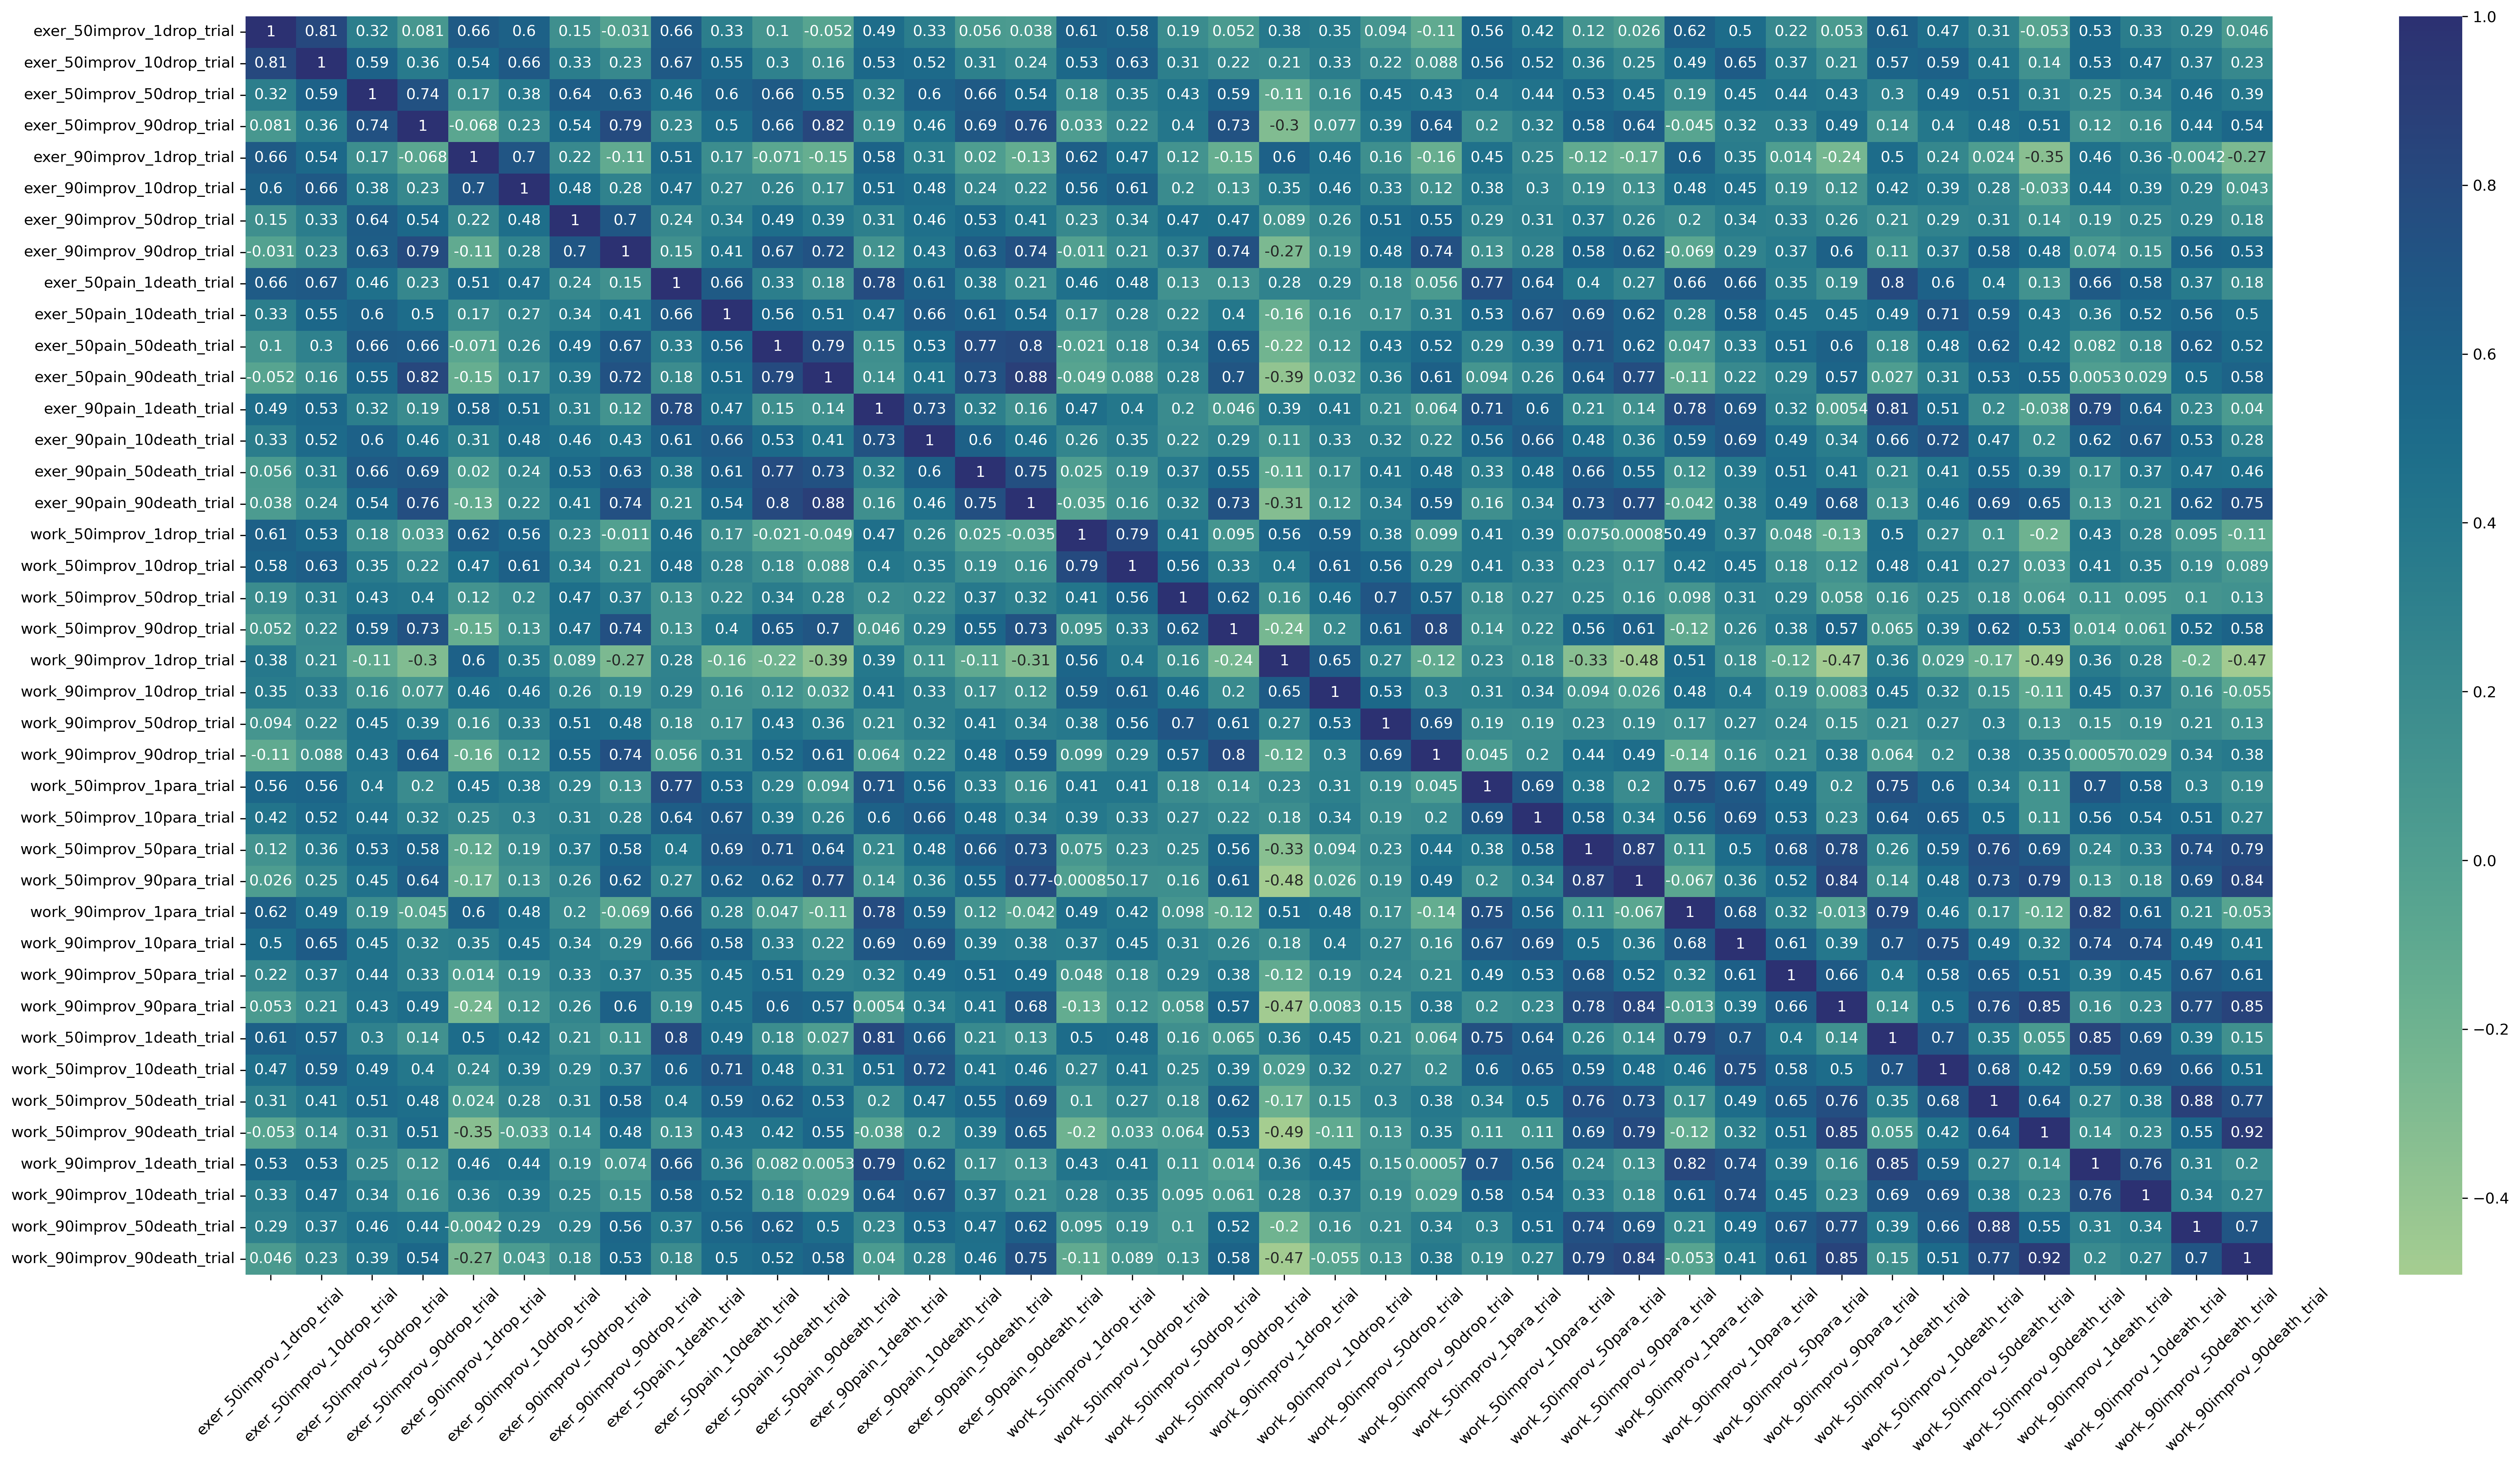

In [11]:
plt.figure(figsize=(30,15), dpi=300)
sns.heatmap(risk_questions_df.corr(), annot=True, cmap='crest')
plt.xticks(rotation=45)
plt.savefig(os.path.join(WD, 'figures/risk_questions_correlations.png'))

In [12]:
# Create correlation matrix
corrs = risk_questions_df.corr().stack().reset_index()
corrs.columns = ['risk_question1', 'risk_question2', 'correlation']

In [13]:
# Create a mapping between the risk question and its number on the REDCap survey
questions_map = pd.DataFrame({'question': list(complete_df.columns[12:-2]),
                              'question_number': list(range(10, 50))})

# Merge with correlations dataframe so that we have question numbers
corrs = corrs.merge(questions_map, how='left', left_on='risk_question1', right_on='question')
corrs.drop(columns='question', inplace=True)
corrs.rename(columns={'question_number': 'risk_question1_number'}, inplace=True)
corrs = corrs.merge(questions_map, how='left', left_on='risk_question2', right_on='question')
corrs.drop(columns='question', inplace=True)
corrs.rename(columns={'question_number': 'risk_question2_number'}, inplace=True)
corrs

risk_question1               risk_question2  correlation  \
0       exer_50improv_1drop_trial    exer_50improv_1drop_trial     1.000000   
1       exer_50improv_1drop_trial   exer_50improv_10drop_trial     0.812465   
2       exer_50improv_1drop_trial   exer_50improv_50drop_trial     0.319864   
3       exer_50improv_1drop_trial   exer_50improv_90drop_trial     0.080692   
4       exer_50improv_1drop_trial    exer_90improv_1drop_trial     0.661380   
...                           ...                          ...          ...   
1595  work_90improv_90death_trial  work_50improv_90death_trial     0.921608   
1596  work_90improv_90death_trial   work_90improv_1death_trial     0.204756   
1597  work_90improv_90death_trial  work_90improv_10death_trial     0.272263   
1598  work_90improv_90death_trial  work_90improv_50death_trial     0.699947   
1599  work_90improv_90death_trial  work_90improv_90death_trial     1.000000   

      risk_question1_number  risk_question2_number  
0                        10                     10  
1                        10                     11  
2                        10                     12  
3                        10                     13  
4                        10                     14  
...                     ...                    ...  
1595                     49                     45  
1596                     49                     46  
1597                     49                     47  
1598                     49                     48  
1599                     49                     49  

[1600 rows x 5 columns]

In [14]:
corrs = corrs[corrs.correlation < 1].copy()
corrs.sort_values('correlation', ascending=False, inplace=True)
corrs['sorted_pair'] = corrs[['risk_question1', 'risk_question2']].apply(sorted, axis=1).apply(tuple)
corrs = corrs[~corrs.duplicated(subset='sorted_pair', keep='first')]
corrs = corrs.drop(columns='sorted_pair')
corrs

risk_question1               risk_question2  correlation  \
1595  work_90improv_90death_trial  work_50improv_90death_trial     0.921608   
455     exer_50pain_90death_trial    exer_90pain_90death_trial     0.884767   
1398  work_50improv_50death_trial  work_90improv_50death_trial     0.883421   
1067   work_50improv_50para_trial   work_50improv_90para_trial     0.867139   
1591  work_90improv_90death_trial   work_90improv_90para_trial     0.852916   
...                           ...                          ...          ...   
460     exer_50pain_90death_trial    work_90improv_1drop_trial    -0.389705   
1260   work_90improv_90para_trial    work_90improv_1drop_trial    -0.467742   
1580  work_90improv_90death_trial    work_90improv_1drop_trial    -0.470108   
1100   work_50improv_90para_trial    work_90improv_1drop_trial    -0.475841   
1420  work_50improv_90death_trial    work_90improv_1drop_trial    -0.490904   

      risk_question1_number  risk_question2_number  
1595                     49                     45  
455                      21                     25  
1398                     44                     48  
1067                     36                     37  
1591                     49                     41  
...                     ...                    ...  
460                      21                     30  
1260                     41                     30  
1580                     49                     30  
1100                     37                     30  
1420                     45                     30  

[780 rows x 5 columns]

In [15]:
corrs.to_csv(os.path.join(WD, 'output/risk_survey_correlation.csv'), index=False)

In [17]:
risk_questions_df.shape

(81, 40)

In [21]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data['feature'] = risk_questions_df.columns 
  
# calculating VIF for each feature 
vif_data['vif'] = [variance_inflation_factor(risk_questions_df.values, i) 
                   for i in range(len(risk_questions_df.columns))]
vif_data.sort_values(by='vif', ascending=False, inplace=True)
vif_data

feature        vif
4     exer_90improv_1drop_trial  68.833830
20    work_90improv_1drop_trial  67.010383
12     exer_90pain_1death_trial  65.290213
28    work_90improv_1para_trial  63.636998
0     exer_50improv_1drop_trial  57.661597
17   work_50improv_10drop_trial  57.346850
16    work_50improv_1drop_trial  53.192230
5    exer_90improv_10drop_trial  48.722384
32   work_50improv_1death_trial  48.096195
8      exer_50pain_1death_trial  47.981312
11    exer_50pain_90death_trial  47.438683
21   work_90improv_10drop_trial  46.503601
1    exer_50improv_10drop_trial  41.843743
31   work_90improv_90para_trial  40.523794
27   work_50improv_90para_trial  39.461992
36   work_90improv_1death_trial  38.848912
24    work_50improv_1para_trial  37.713630
26   work_50improv_50para_trial  32.214765
39  work_90improv_90death_trial  30.683838
22   work_90improv_50drop_trial  30.129413
35  work_50improv_90death_trial  30.083420
13    exer_90pain_10death_trial  28.002132
29   work_90improv_10para_trial  25.281854
10    exer_50pain_50death_trial  23.729496
33  work_50improv_10death_trial  23.721073
25   work_50improv_10para_trial  21.544839
19   work_50improv_90drop_trial  21.289624
18   work_50improv_50drop_trial  21.019363
15    exer_90pain_90death_trial  20.825778
34  work_50improv_50death_trial  19.006296
9     exer_50pain_10death_trial  18.623075
38  work_90improv_50death_trial  18.456381
23   work_90improv_90drop_trial  17.701171
2    exer_50improv_50drop_trial  17.527137
37  work_90improv_10death_trial  16.961514
6    exer_90improv_50drop_trial  16.056911
3    exer_50improv_90drop_trial  15.106425
7    exer_90improv_90drop_trial  14.654829
14    exer_90pain_50death_trial  14.082011
30   work_90improv_50para_trial  11.307344